In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

#https://www.kaggle.com/datasets/gunjansanjaykadam/tumorrr

In [ ]:
path_No = '/kaggle/input/tumorrr/tumorr/no/*'
path_Yes = '/kaggle/input/tumorrr/tumorr/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))


all_data = tumor + no_tumor


data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

Augmented Data Shape: (253, 128, 128, 3)
Augmented Labels Shape: (253,)
Combined Data Shape: (1012, 128, 128, 3)
Combined Labels Shape: (1012,)


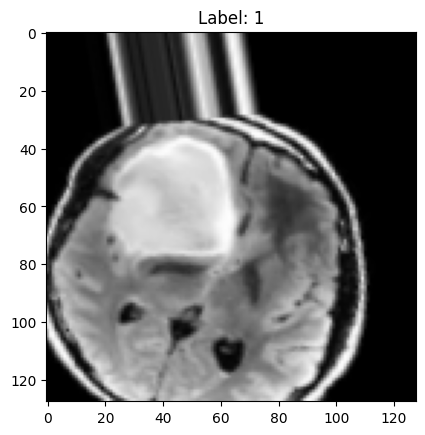

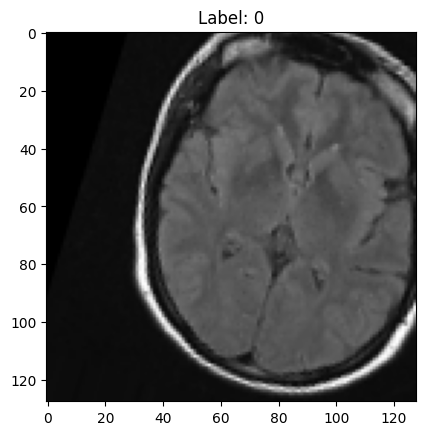

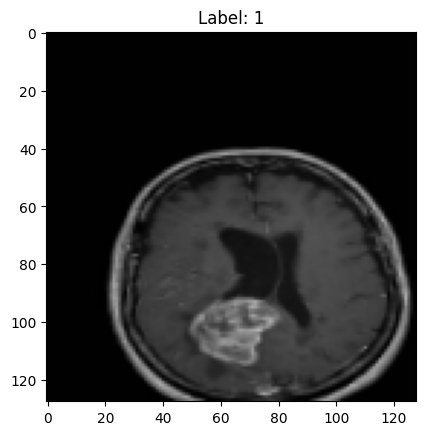

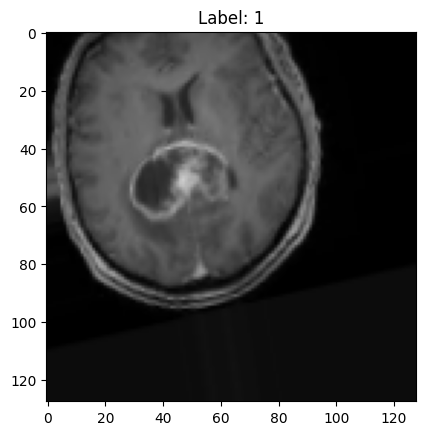

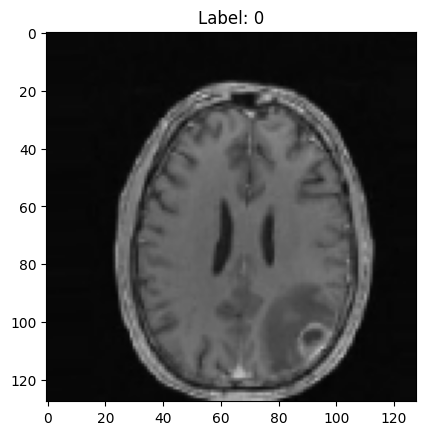

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_data = []
augmented_labels = []

for image, label in all_data:
  image = image.reshape((1,) + image.shape)
  for batch in datagen.flow(image, batch_size=1):
    augmented_data.append(batch[0])
    augmented_labels.append(label)
    break

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)


print("Augmented Data Shape:", augmented_data.shape)
print("Augmented Labels Shape:", augmented_labels.shape)


data = np.concatenate((data, augmented_data), axis=0)
labels = np.concatenate((labels, augmented_labels), axis=0)

print("Combined Data Shape:", data.shape)
print("Combined Labels Shape:", labels.shape)

for x_batch, y_batch in datagen.flow(data, labels, batch_size=9):
  for i in range(0, 5):
    plt.imshow(x_batch[i].astype('uint8'))
    plt.title(f'Label: {y_batch[i]}')
    plt.show()
  break

In [ ]:
print("Number of labels:", len(labels))
print("Number of data points:", len(data))

Number of labels: 1012
Number of data points: 1012


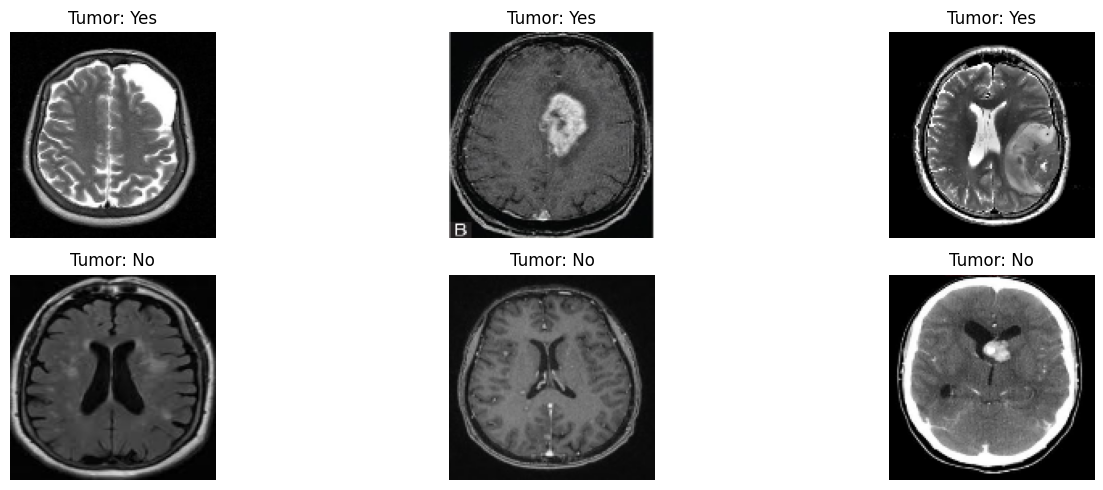

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

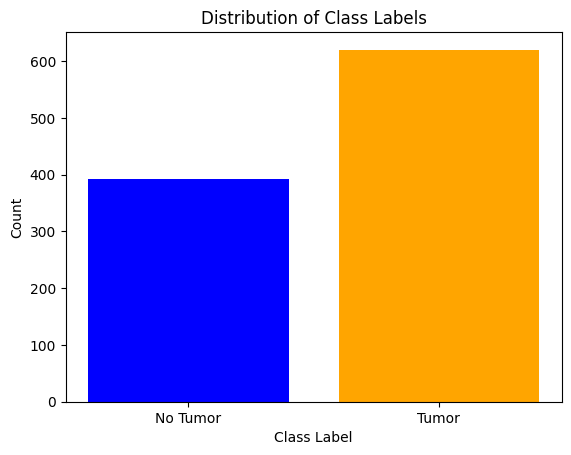

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [ ]:
x_train= x_train /255.0
x_test = x_test / 255.0

In [ ]:
print("Minimum value of the scaled data:", x_train.min())
print("Maximum value of the scaled data:",  x_train.max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

back = myCallback()

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks=[back])

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step - accuracy: 0.6138 - loss: 0.6499 - val_accuracy: 0.6543 - val_loss: 0.6044
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.6831 - loss: 0.6198 - val_accuracy: 0.7222 - val_loss: 0.5960
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - accuracy: 0.7112 - loss: 0.5723 - val_accuracy: 0.7469 - val_loss: 0.5670
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.7625 - loss: 0.5353 - val_accuracy: 0.7654 - val_loss: 0.5353
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.7357 - loss: 0.5564 - val_accuracy: 0.7222 - val_loss: 0.5396
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.7026 - loss: 0.5441 - val_accuracy: 0.7716 - val_loss: 0.5373
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 528ms/step - accuracy: 0.7932 - loss: 0.4662 - val_accuracy: 0.7778 - val_loss: 0.5284
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.7652 - loss: 0.4915 - 

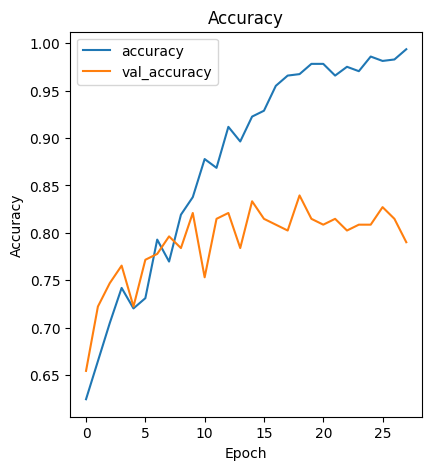

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

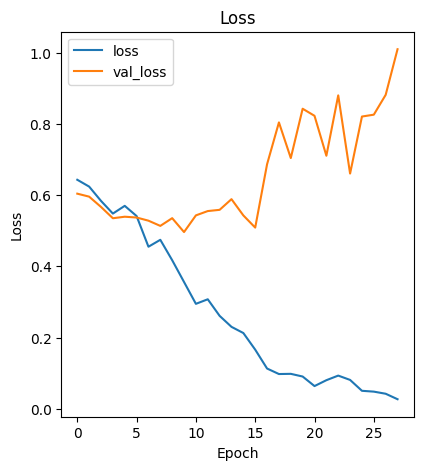

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7166 - loss: 1.3105
Test Loss: 1.5242748260498047
Test Accuracy: 0.738916277885437


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


<Figure size 800x600 with 0 Axes>

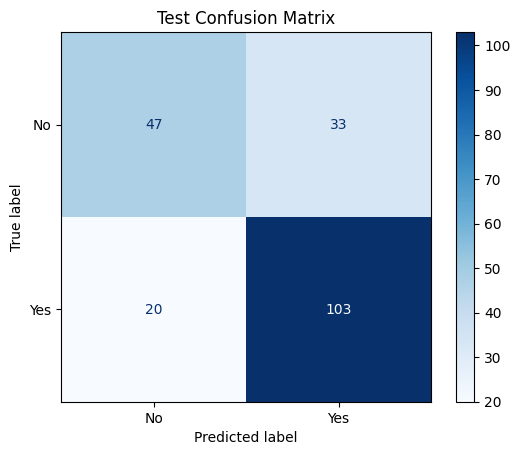

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


y_test_pred_probs = model.predict(x_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

cm_test = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm_test, title='Test Confusion Matrix')